# Introducción

Este notebook implementa un **Double Deep Q-Network (DDQN)** para resolver el juego **BeamRider** del conjunto Atari utilizando el entorno **ALE/BeamRider-v5** de *Gymnasium*.
El objetivo es entrenar un agente que aprenda a **maximizar su puntuación** destruyendo enemigos y evitando obstáculos mientras navega por el espacio.

---

# El Problema: BeamRider

**BeamRider** es un juego clásico de Atari donde el jugador controla una nave espacial que debe:

- Destruir enemigos alienígenas para obtener puntos
- Evitar ser golpeado por proyectiles enemigos
- Navegar a través de diferentes sectores del espacio
- Maximizar la puntuación antes de perder todas las vidas

---

## Especificaciones Técnicas

### Espacio de Acciones

- **Tipo:** Discreto (9 acciones)
  - `0`: NOOP (No hacer nada)
  - `1`: FIRE (Disparar)
  - `2`: UP (Mover hacia arriba)
  - `3`: RIGHT (Mover hacia la derecha)
  - `4`: LEFT (Mover hacia la izquierda)
  - `5`: DOWN (Mover hacia abajo)
  - `6`: UPRIGHT (Mover diagonalmente arriba-derecha)
  - `7`: RIGHTFIRE (Mover hacia la derecha y disparar)
  - `8`: LEFTIFIRE (Mover hacia la izquierda y disparar)

---

### Espacio de Observaciones

- **Tipo:** Imágenes RGB
- **Dimensión Original:** 210 x 160 x 3 (Alto x Ancho x Canales)
- **Dimensión Procesada:** 4 x 84 x 84 (Frame Stack x Alto x Ancho)
  - Se convierten a escala de grises
  - Se redimensionan a 84x84 píxeles
  - Se apilan 4 frames consecutivos para capturar movimiento
  - Se aplica frame skipping (4 frames) para reducir redundancia
  - Se usa max pooling entre frames para evitar flickering

### Sistema de Recompensas

- **Destruir enemigos:** Puntos variables según el tipo de enemigo
- **Completar sectores:** Bonificaciones por progreso
- **Supervivencia:** Recompensa implícita por mantenerse vivo
- **Game Over:** El juego termina cuando se pierden todas las vidas

### Estados Finales

- **Pérdida de vida:** Reducción en el número de vidas restantes
- **Game Over:** Todas las vidas perdidas
- **Timeout:** Superar el límite máximo de pasos por episodio


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from pathlib import Path
from collections import deque
import random
from datetime import datetime
import json
import csv
import cv2
import ale_py
import gymnasium as gym

gym.register_envs(ale_py)

# ¿Por qué DDQN?

Se escogió **Double Deep Q-Network (DDQN)** como método principal para este proyecto debido a sus ventajas específicas para juegos de Atari que requieren procesamiento de imágenes y manejo de espacios de acción discretos complejos.

---

## Ventajas de DDQN para BeamRider

- **Procesamiento de Imágenes:**
  Las observaciones son frames de 4 x 84 x 84  píxeles. DDQN utiliza redes neuronales convolucionales que pueden extraer características relevantes de las imágenes del juego.

- **Espacio de Acciones Discreto:**
  BeamRider tiene múltiples acciones discretas (moverse, disparar, combinaciones). DDQN puede manejar eficientemente este espacio de acciones estimando valores Q para cada acción.

- **Reducción del Sesgo de Sobreestimación:**
  DDQN mejora sobre DQN al usar la red principal para seleccionar acciones y la red objetivo para evaluarlas, reduciendo el sesgo de sobreestimación que es común en Q-learning.

- **Estabilidad de Entrenamiento:**
  Las técnicas de DDQN (target network, experience replay, frame stacking) proporcionan la estabilidad necesaria para aprender políticas complejas en entornos visuales.

- **Eficiencia de Muestreo:**
  Experience replay permite reutilizar experiencias pasadas múltiples veces, lo cual es crucial para juegos de Atari donde conseguir experiencias es computacionalmente costoso.


## Arquitectura del Sistema

### Componentes Principales

1. **BeamRiderEnvironment**: Wrapper del entorno Atari con preprocesamiento
2. **DDQNNetwork**: Red neuronal convolucional para aproximar función Q
3. **DDQNAgent**: Agente que toma decisiones usando epsilon-greedy
4. **DDQNUpdater**: Maneja el entrenamiento y actualización de pesos con Double DQN
5. **ReplayBuffer**: Almacena experiencias para replay con priorización
6. **Logger**: Sistema de logging y monitoreo de métricas

In [6]:
SEED = 42

class BeamRiderEnvironment:
    def __init__(self, render_mode=None, seed=None, frame_skip=4, frame_stack=4):
        self.env = gym.make('ALE/BeamRider-v5', render_mode=render_mode, frameskip=1)
        self.seed = seed
        self.frame_skip = frame_skip
        self.frame_stack = frame_stack
        
        # Frame buffer for max pooling
        self.frame_buffer = deque(maxlen=2)
        
        # Stack of frames for temporal information
        self.frame_stack_buffer = deque(maxlen=frame_stack)
        
        self.observation_space = gym.spaces.Box(
            low=0, high=255, 
            shape=(frame_stack, 84, 84), 
            dtype=np.uint8
        )
        self.action_space = self.env.action_space
        
    def reset(self):
        observation, info = self.env.reset(seed=self.seed)
        
        # Process initial frame
        processed_frame = self._preprocess_frame(observation)
        
        # Fill frame stack with initial frame
        for _ in range(self.frame_stack):
            self.frame_stack_buffer.append(processed_frame)
        
        return self._get_stacked_frames(), info
    
    def step(self, action):
        total_reward = 0
        done = False
        info = {}
        
        # Frame skipping with max pooling
        for i in range(self.frame_skip):
            observation, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            done = terminated or truncated
            
            # Store last two frames for max pooling
            self.frame_buffer.append(observation)
            
            if done:
                break
        
        # Max pooling over last two frames
        if len(self.frame_buffer) == 2:
            max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        else:
            max_frame = self.frame_buffer[0]
        
        # Preprocess and add to frame stack
        processed_frame = self._preprocess_frame(max_frame)
        self.frame_stack_buffer.append(processed_frame)
        
        return self._get_stacked_frames(), total_reward, terminated, truncated, info
    
    def _preprocess_frame(self, frame):
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        # Resize to 84x84
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        
        return resized.astype(np.uint8)
    
    def _get_stacked_frames(self):
        return np.array(list(self.frame_stack_buffer), dtype=np.uint8)
    
    def render(self):
        return self.env.render()
    
    def close(self):
        self.env.close()
    
    def get_action_space_size(self):
        return self.action_space.n
    
    def get_observation_space_shape(self):
        return self.observation_space.shape

In [7]:
beam_rider_env = BeamRiderEnvironment(render_mode=None, seed=SEED)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [8]:
print(f"Action space: {beam_rider_env.action_space}")
print(f"Observation space: {beam_rider_env.observation_space}")
print(f"Action space size: {beam_rider_env.get_action_space_size()}")
print(f"Observation space shape: {beam_rider_env.get_observation_space_shape()}")

Action space: Discrete(9)
Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space size: 9
Observation space shape: (4, 84, 84)


Como podemos observar en el espacio de observación, tenemos un tensor de forma (4, 84, 84) que representa 4 frames apilados de 84x84 píxeles en escala de grises. Este preprocesamiento es estándar para juegos de Atari y permite al agente capturar información temporal del movimiento.

## Red Neuronal DDQN

### Arquitectura Convolucional

La red neuronal utilizada para aproximar la **función Q** en este proyecto utiliza una arquitectura convolucional específicamente diseñada para procesar imágenes de juegos de Atari:

#### Capas Convolucionales:
1. **Primera capa:** `Conv2d(4, 32, 8, 4)` → 32 filtros de 8x8 con stride 4
2. **Segunda capa:** `Conv2d(32, 64, 4, 2)` → 64 filtros de 4x4 con stride 2  
3. **Tercera capa:** `Conv2d(64, 64, 3, 1)` → 64 filtros de 3x3 con stride 1

#### Capas Densas:
1. **Capa densa:** `Linear(3136, 512)` → 512 neuronas
2. **Capa de salida:** `Linear(512, action_dim)` → Valores Q para cada acción

#### Funciones de Activación:
- **ReLU** en todas las capas excepto la de salida
- **Inicialización:** Xavier Uniform para estabilidad

---

### Razones para esta Elección

- **Capas Convolucionales:**
  Diseñadas para capturar características espaciales de las imágenes del juego, como posiciones de enemigos, proyectiles y la nave del jugador.

- **Reducción Progresiva:**
  Los strides grandes en las primeras capas reducen rápidamente la dimensionalidad mientras mantienen información importante.

- **Frame Stacking:**
  Los 4 canales de entrada permiten al modelo capturar movimiento y velocidad de objetos.

- **Tamaño de Red:**
  512 neuronas en la capa densa proporcionan suficiente capacidad para modelar la complejidad del juego sin sobreajuste.


In [9]:
class DDQNNetwork(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(DDQNNetwork, self).__init__()
        
        # Convolutional layers for image processing
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Calculate the size of the flattened features
        # For 84x84 input: ((84-8)/4+1)=20, ((20-4)/2+1)=9, ((9-3)/1+1)=7
        # So conv_output_size = 64 * 7 * 7 = 3136
        conv_output_size = 64 * 7 * 7
        
        # Dense layers
        self.dense_layers = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Normalize input to [0, 1] range
        x = x.float() / 255.0
        
        # Apply convolutional layers
        x = self.conv_layers(x)
        
        # Flatten for dense layers
        x = x.view(x.size(0), -1)
        
        # Apply dense layers
        x = self.dense_layers(x)
        
        return x

## Proceso de Entrenamiento

El entrenamiento del agente se basa en el algoritmo **Double Deep Q-Network (DDQN)**, que mejora sobre DQN al reducir el sesgo de sobreestimación común en Q-learning.

---

### Algoritmo DDQN Paso a Paso

#### Inicialización
- Crear **Q-Network** y **Target Network** (inicialmente con los mismos pesos).
- Inicializar un **Replay Buffer** vacío para almacenar experiencias.
- Establecer **ε = 1.0** para máxima exploración al inicio.

#### Para cada episodio
1. **Resetear entorno** → obtener el estado inicial (stack de 4 frames).
2. **Para cada paso del episodio:**
   - Seleccionar acción con estrategia **ε-greedy**.
   - Ejecutar acción en el entorno → obtener `nuevo estado`, `recompensa` y `done`.
   - Almacenar transición en el **Replay Buffer**.
   - **Actualizar Q-Network** usando Double DQN:
     - Usar Q-Network principal para **seleccionar** la mejor acción
     - Usar Target Network para **evaluar** el valor de esa acción
   - Actualizar Target Network cada *N* pasos.
3. **Decrementar ε** gradualmente.

---

### Diferencias Clave entre DQN y DDQN

**DQN clásico:**
```
Q_target = reward + γ * max(Target_Network(next_state))
```

**Double DQN:**
```
best_action = argmax(Q_Network(next_state))  # Seleccionar con red principal
Q_target = reward + γ * Target_Network(next_state)[best_action]  # Evaluar con red objetivo
```

Esta separación reduce el sesgo de sobreestimación porque la red que selecciona no es la misma que evalúa.


# Replay Buffer

In [10]:
class ReplayBuffer:
    def __init__(self, capacity, device='cpu'):
        self.buffer = deque(maxlen=capacity)
        self.device = device

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        state = torch.FloatTensor(np.array(state)).to(self.device)
        action = torch.LongTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# DDQN Agent and DDQN Updater

In [11]:
class DDQNAgent:
    def __init__(
            self,
            action_dim,
            model_dir='models/ddqn',
            input_channels=4
    ):
        self.action_dim = action_dim
        self.input_channels = input_channels
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.epsilon = 1.0

        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

        self.device = device

        self.q_network = DDQNNetwork(input_channels, action_dim).to(self.device)
        self.target_network = DDQNNetwork(input_channels, action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

    def act(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def save(self, episode=None):
        filename = f"ddqn_episode_{episode}.pth" if episode else "ddqn_final.pth"
        filepath = self.model_dir / filename

        checkpoint = {
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'episode': episode
        }

        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")

        if episode is None:
            best_path = self.model_dir / "ddqn_best.pth"
            torch.save(checkpoint, best_path)

    def load(self, filepath=None):
        if filepath is None:
            filepath = self.model_dir / "ddqn_best.pth"
            if not filepath.exists():
                filepath = self.model_dir / "ddqn_final.pth"

        if not Path(filepath).exists():
            print(f"No model found at {filepath}")
            return False

        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])

        print(f"Model loaded from {filepath}")
        return True


class DDQNUpdater:
    def __init__(
            self,
            agent: DDQNAgent,
            target_update_freq=10000,
            buffer_size=100_000,
            batch_size=64,
            lr=2.5e-4,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay_steps=1000000,
            device='cpu'
    ):
        self.agent = agent
        self.device = device
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        
        # Calculate linear decay rate
        self.epsilon_decay = (epsilon - epsilon_min) / epsilon_decay_steps
        
        print(f"Epsilon decay per step: {self.epsilon_decay:.8f}")
        print(f"Epsilon will decay over {epsilon_decay_steps:,} steps")

        self.optimizer = optim.Adam(self.agent.q_network.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()  # Huber Loss for stability

        self.update_counter = 0

        self.replay_buffer = ReplayBuffer(buffer_size, self.device)

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        current_q_values = self.agent.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            # Double DQN: Use main network to select actions, target network to evaluate
            next_actions = self.agent.q_network(next_states).argmax(1)
            next_q_values = self.agent.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.agent.q_network.parameters(), 10.0)  # Gradient clipping
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.agent.target_network.load_state_dict(self.agent.q_network.state_dict())

        # Linear epsilon decay based on steps
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
            self.agent.epsilon = self.epsilon

        return loss.item()

    def save(self, episode=None):
        checkpoint = {
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'update_counter': self.update_counter,
            'episode': episode
        }

        filename = f"ddqn_updater_{episode}.pth" if episode else "ddqn_updater_final.pth"
        filepath = self.agent.model_dir / filename
        torch.save(checkpoint, filepath)

    def load(self, filepath=None):
        if filepath is None:
            filepath = self.agent.model_dir / "ddqn_updater_final.pth"

        if not Path(filepath).exists():
            print(f"No updater checkpoint found at {filepath}")
            return False

        checkpoint = torch.load(filepath, map_location=self.device)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint.get('epsilon', self.epsilon_min)
        self.update_counter = checkpoint.get('update_counter', 0)
        self.agent.epsilon = self.epsilon

        print(f"Updater loaded from {filepath}")
        return True

In [12]:
class Logger:
    def __init__(self, log_dir='logs/ddqn'):
        self.log_dir = log_dir
        self.history = {
            'episodes': [],
            'rewards': [],
            'steps': [],
            'timestamps': [],
            'td_losses': [],
            'epsilons': [],
            'network_losses': []
        }

        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        
        # Initialize CSV logging
        self.csv_path = os.path.join(log_dir, 'training_log.csv')
        self._init_csv()

    def log_episode(self, episode, reward, steps, td_loss=None, epsilon=None, network_loss=None):
        timestamp = datetime.now().isoformat()
        self.history['episodes'].append(episode)
        self.history['rewards'].append(reward)
        self.history['steps'].append(steps)
        self.history['timestamps'].append(timestamp)

        # Log to CSV
        self._log_to_csv(episode, reward, steps, timestamp, td_loss, epsilon, network_loss)

    def save_history(self, filename=None):
        if filename is None:
            filename = f"training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

        filepath = os.path.join(self.log_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(self.history, f, indent=2)

        print(f"Training history saved to {filepath}")

    def get_history(self):
        return self.history

    def save(self, filepath):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        np.savez(filepath, **self.history)
        print(f"Training history saved to {filepath}")

    def get_statistics(self, last_n=100):
        if len(self.history['rewards']) < last_n:
            last_n = len(self.history['rewards'])

        if last_n == 0:
            return {}

        recent_rewards = self.history['rewards'][-last_n:]
        recent_steps = self.history['steps'][-last_n:]

        stats = {
            'mean_reward': sum(recent_rewards) / len(recent_rewards),
            'max_reward': max(recent_rewards),
            'min_reward': min(recent_rewards),
            'mean_steps': sum(recent_steps) / len(recent_steps),
            'total_episodes': len(self.history['episodes'])
        }

        return stats

    def log_training_metrics(self, episode, loss=None, epsilon=None, eval_reward=None, td_loss=None):
        """Log additional training metrics to history"""
        if loss is not None:
            self.history['network_losses'].append(loss)
        if epsilon is not None:
            self.history['epsilons'].append(epsilon)
        if td_loss is not None:
            self.history['td_losses'].append(td_loss)

    def _init_csv(self):
        """Initialize CSV file with headers"""
        with open(self.csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['episode', 'reward', 'steps', 'timestamp', 'td_loss', 'epsilon', 'network_loss', 'eval_reward'])

    def _log_to_csv(self, episode, reward, steps, timestamp, td_loss=None, epsilon=None, network_loss=None, eval_reward=None):
        """Append a row to the CSV file"""
        with open(self.csv_path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([episode, reward, steps, timestamp, td_loss, epsilon, network_loss, eval_reward])

    def close(self):
        """Close the logger and report save locations"""
        print(f"CSV training log saved to {self.csv_path}")

# Training Loop

In [13]:
def train_ddqn(
    episodes=1000,
    max_steps=18000,  # Atari games can be longer than simple control tasks
    save_freq=100,
    eval_freq=50,
    eval_episodes=5,
    seed=42
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = BeamRiderEnvironment(render_mode=None, seed=seed)
    eval_env = BeamRiderEnvironment(render_mode=None, seed=seed + 1000)

    input_channels = 4  # Frame stack size
    action_dim = env.get_action_space_size()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    agent = DDQNAgent(
        action_dim=action_dim,
        input_channels=input_channels
    )

    # Atari-specific hyperparameters
    expected_steps_per_episode = 1500  # BeamRider episodes can be long
    total_expected_steps = episodes * expected_steps_per_episode
    epsilon_decay_steps = int(total_expected_steps * 0.8)  # 80% of training for exploration

    agent_updater = DDQNUpdater(
        agent=agent,
        lr=2.5e-4,  # Lower learning rate for Atari
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay_steps=epsilon_decay_steps,
        buffer_size=100_000,  # Larger buffer for Atari
        batch_size=64,
        target_update_freq=10000,  # Less frequent target updates for Atari
        device=device,
    )

    logger = Logger()
    best_avg_reward = -float('inf')
    training_info = {
        'start_time': datetime.now().isoformat(),
        'episodes': episodes,
        'seed': seed,
        'device': agent.device,
        'epsilon_decay_steps': epsilon_decay_steps,
        'environment': 'ALE/BeamRider-v5'
    }

    print(f"Starting DDQN training on {agent.device}")
    print(f"Input channels: {input_channels}, Action dimension: {action_dim}")
    print(f"Expected total steps: {total_expected_steps:,.0f}")
    print(f"Epsilon decay steps: {epsilon_decay_steps:,}")
    print("-" * 50)

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        losses = []

        for step in range(max_steps):
            action = agent.act(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent_updater.store_transition(state, action, reward, next_state, done)

            loss = agent_updater.update()
            if loss is not None:
                losses.append(loss)

            total_reward += reward
            steps += 1
            state = next_state

            if done:
                break

        # Calculate average loss for this episode
        avg_loss = np.mean(losses) if losses else None
        
        # Log episode with TD loss and epsilon
        logger.log_episode(
            episode=episode, 
            reward=total_reward, 
            steps=steps, 
            td_loss=avg_loss, 
            epsilon=agent_updater.epsilon,
            network_loss=avg_loss
        )

        # Log additional metrics to history
        logger.log_training_metrics(
            episode=episode,
            loss=avg_loss,
            epsilon=agent_updater.epsilon,
            td_loss=avg_loss
        )

        if episode % 10 == 0:
            avg_reward_100 = np.mean(logger.get_history()['rewards'][-100:]) if episode >= 99 else np.mean(logger.get_history()['rewards'])
            loss_str = f"{avg_loss:.4f}" if avg_loss is not None else "N/A"
            print(f"Episode {episode:4d} | Reward: {total_reward:7.1f} | Steps: {steps:4d} | "
                  f"Avg100: {avg_reward_100:7.1f} | Loss: {loss_str} | ε: {agent_updater.epsilon:.3f}")

        if episode % eval_freq == 0 and episode > 0:
            eval_rewards = []
            for _ in range(eval_episodes):
                state, _ = eval_env.reset()
                eval_reward = 0
                for _ in range(max_steps):
                    action = agent.act(state, training=False)
                    state, reward, terminated, truncated, _ = eval_env.step(action)
                    eval_reward += reward
                    if terminated or truncated:
                        break
                eval_rewards.append(eval_reward)

            avg_eval_reward = np.mean(eval_rewards)
            print(f"  [EVAL] Average reward over {eval_episodes} episodes: {avg_eval_reward:.1f}")

            # Log evaluation results to CSV
            logger.log_training_metrics(episode=episode, eval_reward=avg_eval_reward)
            
            # Update CSV with eval reward for this episode
            logger._log_to_csv(episode, total_reward, steps, datetime.now().isoformat(), 
                             avg_loss, agent_updater.epsilon, avg_loss, avg_eval_reward)

            if avg_eval_reward > best_avg_reward:
                best_avg_reward = avg_eval_reward
                agent.save()
                agent_updater.save()
                print(f"  [SAVE] New best model! Average reward: {best_avg_reward:.1f}")

        if episode % save_freq == 0 and episode > 0:
            agent.save(episode)
            agent_updater.save(episode)

    agent.save()
    agent_updater.save()

    training_info['end_time'] = datetime.now().isoformat()
    training_info['final_avg_reward'] = float(np.mean(logger.get_history()['rewards'][-100:]))
    training_info['best_avg_reward'] = float(best_avg_reward)
    training_info['final_epsilon'] = float(agent_updater.epsilon)

    with open('models/ddqn/training_info.json', 'w') as f:
        json.dump(training_info, f, indent=2)

    logger.save('logs/ddqn/training_history.npz')

    print("\n" + "=" * 50)
    print("Training completed!")
    print(f"Final average reward (last 100 episodes): {training_info['final_avg_reward']:.1f}")
    print(f"Best evaluation average reward: {best_avg_reward:.1f}")
    print(f"Final epsilon: {training_info['final_epsilon']:.3f}")
    print(f"Models saved in: models/ddqn/")

    env.close()
    eval_env.close()

    # Close logger
    logger.close()

    return logger.get_history()

In [ ]:
# Start training - Note: This will take several hours to complete
# For demonstration purposes, you might want to use fewer episodes first
train_ddqn(episodes=1000)  # Reduced for demonstration

# Análisis de Resultados

Para este análisis de resultados de BeamRider se han elegido las siguientes métricas:

1. **Recompensa por episodio** (gráfica simple y gráfica con medias móviles)
2. **Pasos por episodio** (duración de los episodios)
3. **Epsilon** (tasa de exploración)
4. **Pérdida de diferencia temporal (TD Loss)**

# ¿Qué nos dice cada métrica?

## Recompensa por episodio
La recompensa por episodio indica qué tanto ha aprendido el agente a jugar BeamRider a lo largo del tiempo. Una recompensa alta significa que el agente ha aprendido a:
- Destruir más enemigos eficientemente
- Evitar ser golpeado por proyectiles
- Sobrevivir más tiempo en el juego
- Maximizar la puntuación

Si la gráfica tiende a crecer con una pendiente pronunciada, significa que el modelo está aprendiendo bien.
Si la gráfica se estabiliza en un valor alto, significa que el modelo está cerca de converger (al menos a un mínimo local).

## Pasos por episodio
En BeamRider, más pasos generalmente significa mejor rendimiento, ya que indica que el agente sobrevive más tiempo.
- Episodios cortos pueden indicar muertes tempranas
- Episodios largos sugieren que el agente ha aprendido a evitar enemigos y sobrevivir
- La variabilidad en los pasos puede indicar inconsistencia en la política

## Epsilon
Examinar cómo evoluciona epsilon nos da una visual de si el decaimiento está bien configurado:
- Inicio alto (1.0) permite exploración completa
- Decaimiento gradual permite transición de exploración a explotación
- Valor mínimo bajo (0.01) permite algo de exploración continua

## Pérdida de diferencia temporal (TD Loss)
La pérdida TD nos indica qué tan bien el modelo está aprendiendo:
- Pérdida alta inicial es normal (red aprendiendo)
- Pérdida decreciente indica convergencia de la función Q
- Pérdida estable sugiere que el modelo ha aprendido representaciones consistentes
- Saltos abruptos podrían indicar inestabilidad en el entrenamiento


Total episodes logged: 1019
Training duration: 1019 episodes


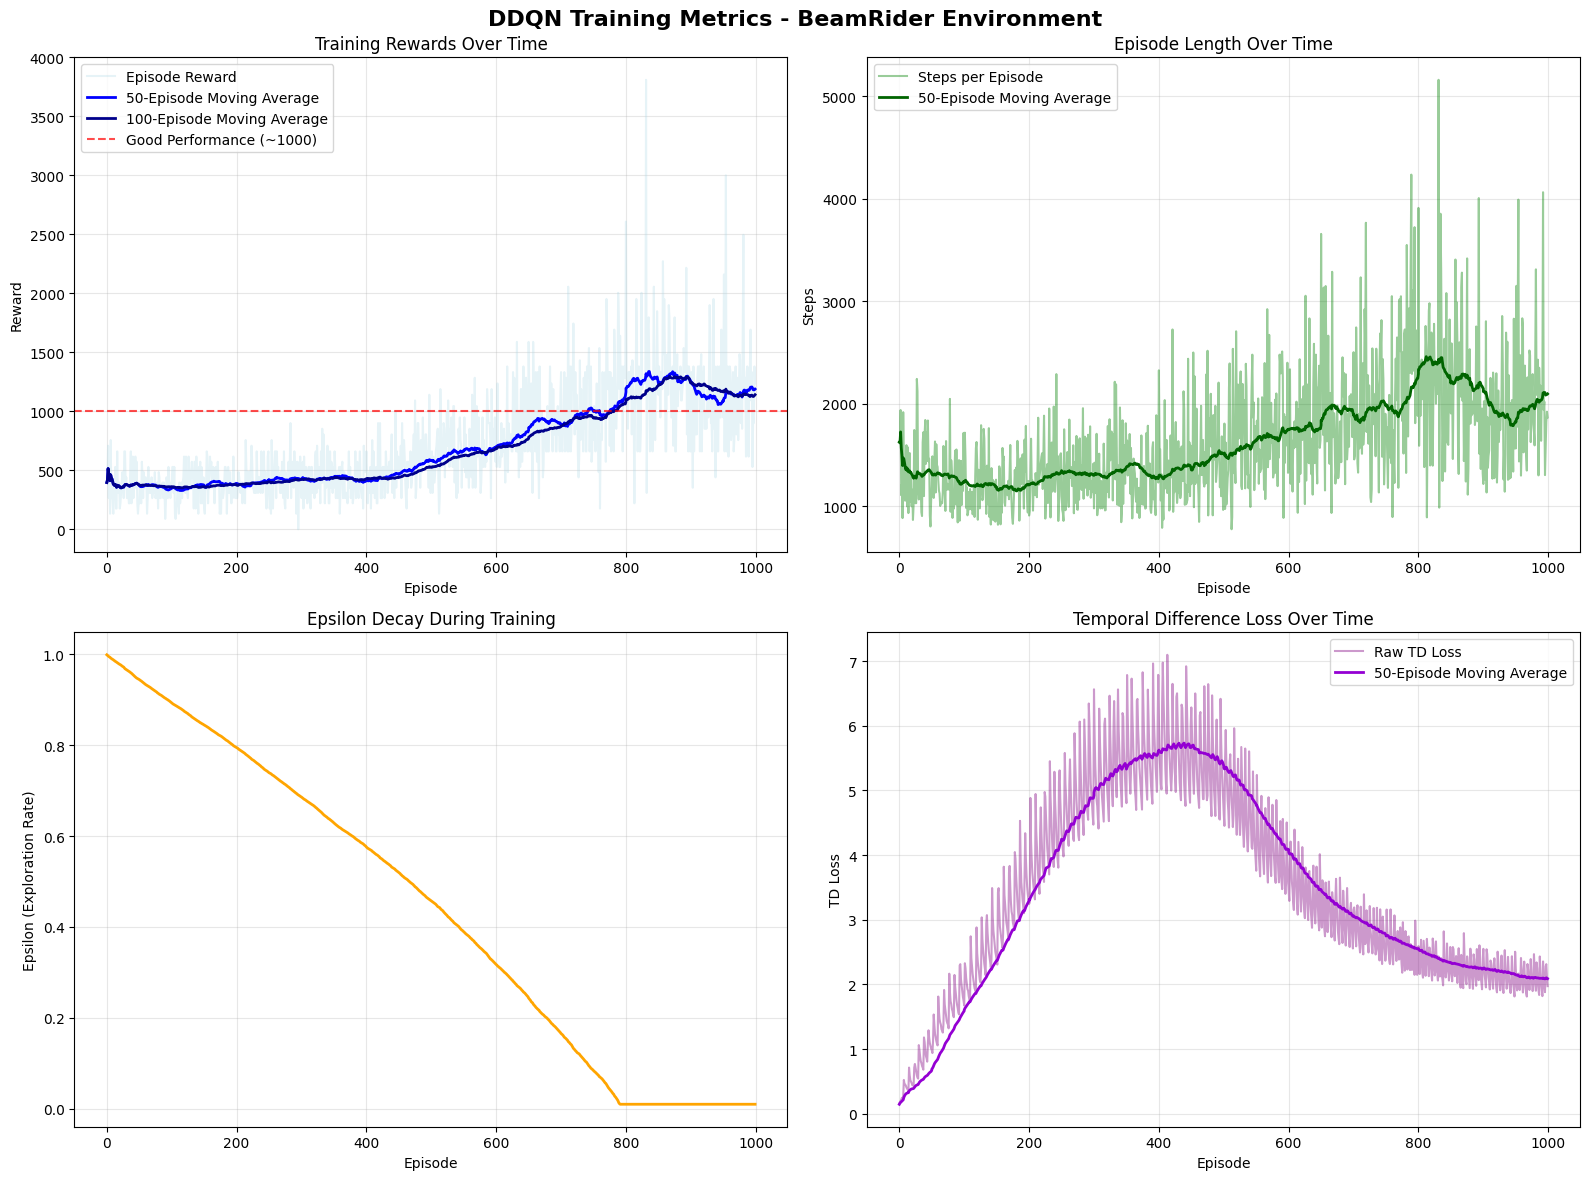

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training data
training_data = pd.read_csv('logs/ddqn/training_log.csv')
print(f"Total episodes logged: {len(training_data)}")
print(f"Training duration: {training_data.shape[0]} episodes")

# Calculate rolling averages for different window sizes
training_data['reward_ma_50'] = training_data['reward'].rolling(window=50, min_periods=1).mean()
training_data['reward_ma_100'] = training_data['reward'].rolling(window=100, min_periods=1).mean()
training_data['steps_ma_50'] = training_data['steps'].rolling(window=50, min_periods=1).mean()
training_data['td_loss_ma_50'] = training_data['td_loss'].rolling(window=50, min_periods=1).mean()

# Create comprehensive training metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DDQN Training Metrics - BeamRider Environment', fontsize=16, fontweight='bold')

# 1. Episode Rewards
axes[0,0].plot(training_data['episode'], training_data['reward'], alpha=0.3, color='lightblue', label='Episode Reward')
axes[0,0].plot(training_data['episode'], training_data['reward_ma_50'], color='blue', linewidth=2, label='50-Episode Moving Average')
axes[0,0].plot(training_data['episode'], training_data['reward_ma_100'], color='darkblue', linewidth=2, label='100-Episode Moving Average')
axes[0,0].axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='Good Performance (~1000)')
axes[0,0].set_xlabel('Episode')
axes[0,0].set_ylabel('Reward')
axes[0,0].set_title('Training Rewards Over Time')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Episode Length (Steps)
axes[0,1].plot(training_data['episode'], training_data['steps'], alpha=0.4, color='green', label='Steps per Episode')
axes[0,1].plot(training_data['episode'], training_data['steps_ma_50'], color='darkgreen', linewidth=2, label='50-Episode Moving Average')
axes[0,1].set_xlabel('Episode')
axes[0,1].set_ylabel('Steps')
axes[0,1].set_title('Episode Length Over Time')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Epsilon Decay
axes[1,0].plot(training_data['episode'], training_data['epsilon'], color='orange', linewidth=2)
axes[1,0].set_xlabel('Episode')
axes[1,0].set_ylabel('Epsilon (Exploration Rate)')
axes[1,0].set_title('Epsilon Decay During Training')
axes[1,0].grid(True, alpha=0.3)

# 4. TD Loss
axes[1,1].plot(training_data['episode'], training_data['td_loss'], alpha=0.4, color='purple', label='Raw TD Loss')
axes[1,1].plot(training_data['episode'], training_data['td_loss_ma_50'], color='darkviolet', linewidth=2, label='50-Episode Moving Average')
axes[1,1].set_xlabel('Episode')
axes[1,1].set_ylabel('TD Loss')
axes[1,1].set_title('Temporal Difference Loss Over Time')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

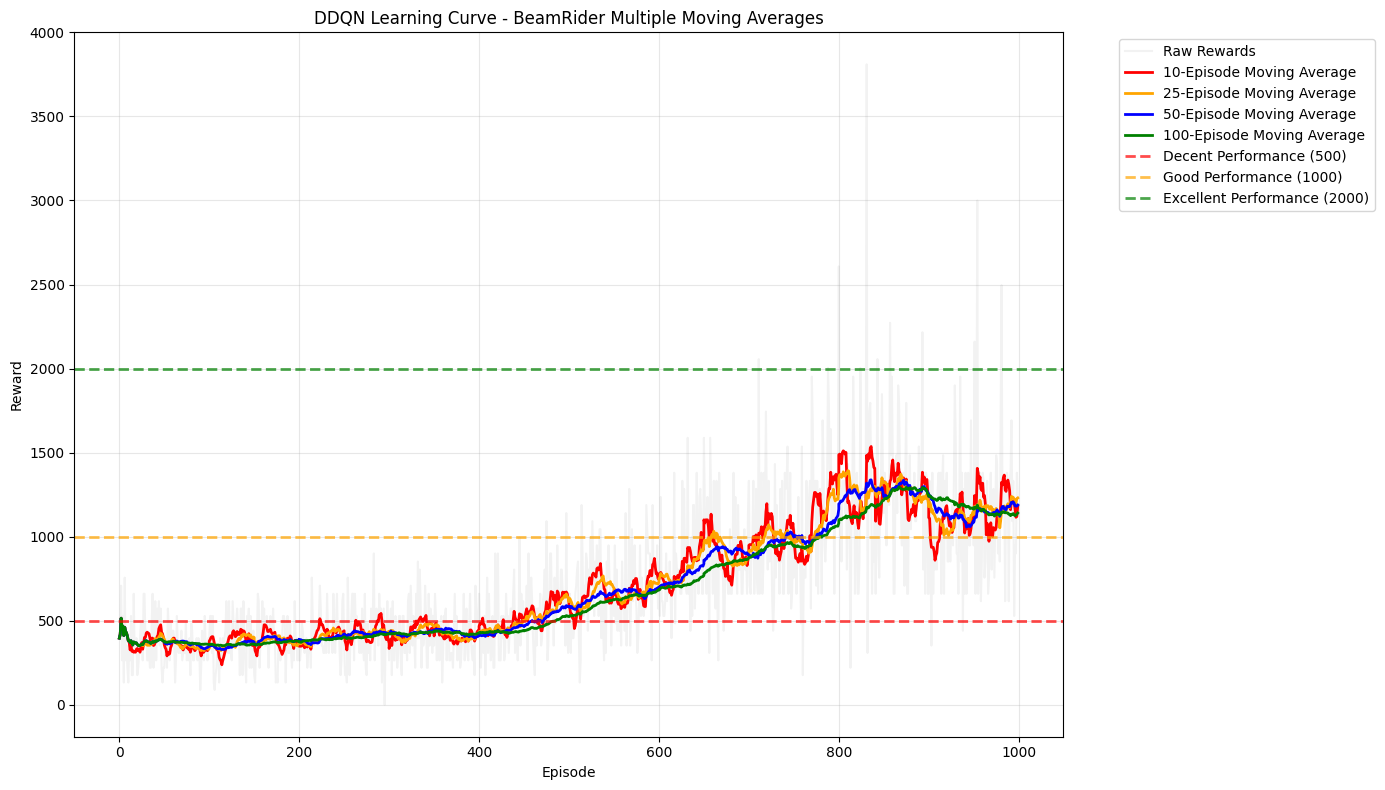

In [17]:
# Advanced analysis: Multiple moving averages for reward trends
window_sizes = [10, 25, 50, 100]
colors = ['red', 'orange', 'blue', 'green']

plt.figure(figsize=(14, 8))
plt.plot(training_data['episode'], training_data['reward'], alpha=0.1, color='gray', label='Raw Rewards')

for window, color in zip(window_sizes, colors):
    if len(training_data) >= window:
        smoothed = training_data['reward'].rolling(window=window, min_periods=1).mean()
        plt.plot(training_data['episode'], smoothed, color=color, linewidth=2,
                label=f'{window}-Episode Moving Average')

plt.axhline(y=500, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Decent Performance (500)')
plt.axhline(y=1000, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Good Performance (1000)')
plt.axhline(y=2000, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Excellent Performance (2000)')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDQN Learning Curve - BeamRider Multiple Moving Averages')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusiones

El agente a pesar de un inicio lento en el entrenamiento (primeros 400 episodios), donde su curva de aprendizaje
parecia estar estancada, logro mejorar bastante de el episodio 400 hasta el 900, donde la recompensa promedio subio
de 400 a 1200 puntos, lo que indica que el agente aprendio a jugar bastante bien.

En promedio una nave enemiga destruida da 40 puntos de reward, lo cual significa que el agente en promedio destruye 30 naves por episodio, esto como se demuestra en el video es un resultado bueno.

Estos resultados tambien se demuestran en la grafica de temporal difference loss, la cual hasta el episodio 400 no hacia mas que
incrementarse (por la fase de exploracion inicial) a partir del episodio 400 se ve que comienza a decrecer de manera constante y pronunciada hasta el ultimo episodio de entrenamiento, lo que indica que el agente esta aprendiendo a predecir mejor los valores Q. Tambien se evidencia que la tendencia a decrecer de el TD error no baja aun en los ultimos episodios, por lo que el agente tiene
mucho mas espacio de aprendizaje si hubiere el tiempo de continuar el entrenamiento.

Los pasos por episodio tambien tienen una tendencia a incrementar, sin embargo la curva es menos pronunciada que los rewards
lo cual puede indicar que el agente no solo aprende a durar mas en la partida, si no que aprende a jugar mas, maximizando las
naves destruidas en el mismo tiempo.

Al final, (episodio 900) se ve que la curva de aprendizaje vuelve a pasar por un periodo de estancamiento, y esto parece tener
relacion con el epsilon el cual llega a su minimo (0.1) en el episodio 800, por lo que vemos que en este problema
la exploracion epsilon es clave para que el agente siga aprendiendo, y si se reduce demasiado pronto el agente puede quedar atrapado en un minimo local.

# Trabajo futuro

Analizando todas las graficas, cada una de ellas muestra inidicios de que el agente no ha llegado a su maximo postencial, y que con mas tiempo de entrenamiento podria mejorar aun mas su rendimiento.

El experimento actual se ha ejecutado por 15 horas, 1000 epochs, un numero mucho mayor (10k, quiza 100k) podria llevar a un rendimiento sobresaliente.